In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from scipy import integrate

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

## Now, I'm going to learn the beautiful soup:

#### 1. a tag:

In [4]:
soup = BeautifulSoup('<b class="boldest">Extremely bold</b>',"html.parser")
tag = soup.b
type(tag)

bs4.element.Tag

a tag has a name, attribute, value

In [39]:
print tag.name
print tag["class"]
print tag.attrs

b
['boldest']
{'class': ['boldest']}


i.e. we can use .attrs to show the dictionary of a specified tag (attr, value).

Also, the things within the begin and the end tag (i.e. within $<b>$ and $</b>$) are strings:

In [40]:
print type(tag.string)
print tag.string

<class 'bs4.element.NavigableString'>
Extremely bold


These strings are objects of the type NavigableString. i.e. we can do further actions such as to find its direct parent:

In [77]:
print tag.string.parent                   # a NavigableString obj
print unicode(tag.string.parent)          # a unicode string
print repr(unicode(tag.string.parent))    # a unicode string (in repr(), if the string is "unicode" encoded, it will begin by u')

#check the types of the above stuffs:
print type(tag.string.parent)             
print type(unicode(tag.string.parent))
print type(repr(unicode(tag.string.parent)))

<p class="story">...</p>
<p class="story">...</p>
u'<p class="story">...</p>'
<class 'bs4.element.Tag'>
<type 'unicode'>
<type 'str'>


or find its parent's parent(now we have the easiest situation, i.e. they have only one direct parent):

In [46]:
print tag.string.parent.parent

<body><b class="boldest">Extremely bold</b></body>


The most common multi-valued attribute is class:

In [47]:
css_soup = BeautifulSoup('<p class="body strikeout"></p>')
print css_soup.p['class']
# ["body", "strikeout"]

css_soup = BeautifulSoup('<p class="body strikeout"></p>', "lxml")
print css_soup.p['class']

['body', 'strikeout']
['body', 'strikeout']


on the other hand, id is not a multi-valued attribute:

In [9]:
id_soup = BeautifulSoup('<p id="my id"></p>')
id_soup.p['id']
# 'my id'

'my id'

Now, let's see a slightly complex situation:

In [46]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""
soup = BeautifulSoup(html_doc, 'html.parser')

First of all, let's see the prettified structure:

In [47]:
print soup.prettify()

<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
  <p class="story">
   Once upon a time there were three little sisters; and their names were
  </p>
  <a class="sister" href="http://example.com/elsie" id="link1">
   Elsie
  </a>
  ,
  <a class="sister" href="http://example.com/lacie" id="link2">
   Lacie
  </a>
  and
  <a class="sister" href="http://example.com/tillie" id="link3">
   Tillie
  </a>
  ;
and they lived at the bottom of a well.
 </body>
</html>
<p class="story">
 ...
</p>



In [48]:
print soup.p

<p class="title"><b>The Dormouse's story</b></p>


apparently, the above is not what I want. I actually would like to obtain all the tags which is labeled as "p". This can be achieved by taking the advantage of the method "find_all":

In [52]:
for tag in soup.find_all("p"):
    print tag
    print tag.name
    print tag.attrs
    print tag["class"]
    print type(tag["class"][0])
    print tag.string
    print "==================================================================================================="

<p class="title"><b>The Dormouse's story</b></p>
p
{u'class': [u'title']}
[u'title']
<type 'unicode'>
The Dormouse's story
<p class="story">Once upon a time there were three little sisters; and their names were</p>
p
{u'class': [u'story']}
[u'story']
<type 'unicode'>
Once upon a time there were three little sisters; and their names were
<p class="story">...</p>
p
{u'class': [u'story']}
[u'story']
<type 'unicode'>
...


In [81]:
for string in soup.strings:
    print(repr(string))
    print repr(string.encode("ascii"))
    print

u'\n'
'\n'

u"The Dormouse's story"
"The Dormouse's story"

u'\n'
'\n'

u'\n'
'\n'

u"The Dormouse's story"
"The Dormouse's story"

u'\n'
'\n'

u'Once upon a time there were three little sisters; and their names were'
'Once upon a time there were three little sisters; and their names were'

u'\n'
'\n'

u'Elsie'
'Elsie'

u',\n'
',\n'

u'Lacie'
'Lacie'

u' and\n'
' and\n'

u'Tillie'
'Tillie'

u';\nand they lived at the bottom of a well.'
';\nand they lived at the bottom of a well.'

u'\n'
'\n'

u'...'
'...'

u'\n'
'\n'



So many spaces there. The spaces can be removed via stripping the strings:

In [84]:
for string in soup.stripped_strings:
    print(repr(string.encode("ascii")))

"The Dormouse's story"
"The Dormouse's story"
'Once upon a time there were three little sisters; and their names were'
'Elsie'
','
'Lacie'
'and'
'Tillie'
';\nand they lived at the bottom of a well.'
'...'


Well, we could also put all the stripped strings into a list:

In [85]:
[repr(string.encode("ascii")) for string in soup.stripped_strings]

['"The Dormouse\'s story"',
 '"The Dormouse\'s story"',
 "'Once upon a time there were three little sisters; and their names were'",
 "'Elsie'",
 "','",
 "'Lacie'",
 "'and'",
 "'Tillie'",
 "';\\nand they lived at the bottom of a well.'",
 "'...'"]

In [86]:
print soup.prettify()

<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
  <p class="story">
   Once upon a time there were three little sisters; and their names were
  </p>
  <a class="sister" href="http://example.com/elsie" id="link1">
   Elsie
  </a>
  ,
  <a class="sister" href="http://example.com/lacie" id="link2">
   Lacie
  </a>
  and
  <a class="sister" href="http://example.com/tillie" id="link3">
   Tillie
  </a>
  ;
and they lived at the bottom of a well.
 </body>
</html>
<p class="story">
 ...
</p>



In [89]:
link = soup.a
print link
print 
# <a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>
for parent in link.parents:
    if parent is None:
        print(parent)
    else:
        print(parent.name)

<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>

body
html
[document]


We've successfully found the parent of the specified tag. This can be verified by seeing the structure obtained from the method soup.prettify().

In [90]:
print soup.name

for child in soup.children:
    print child

[document]


<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</body></html>


<p class="story">...</p>




The above result is understandable since from the method soup.prettify() we know already that $<html>$ and $<p>$ are the direct children of the parent $[document]$.

Now, let's see its descendants:

In [63]:
print soup.body.name
print type(soup.body.descendants)

for child in soup.body.descendants:
    print child

body
<type 'generator'>


<p class="title"><b>The Dormouse's story</b></p>
<b>The Dormouse's story</b>
The Dormouse's story


<p class="story">Once upon a time there were three little sisters; and their names were</p>
Once upon a time there were three little sisters; and their names were


<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>
Elsie
,

<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>
Lacie
 and

<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>
Tillie
;
and they lived at the bottom of a well.


idea: to get all the strings of all the "p" tags:

In [62]:
for single_tag in soup.find_all("p"):
    for string in single_tag:
        print string

<b>The Dormouse's story</b>
Once upon a time there were three little sisters; and their names were
...


Well, not sure if this will be useful. Anyway, let's move on first.

I now have the problem about the type "generator". I'd like to understand both the types "generator" and "iterator" in Python better.

In [9]:
a = [1, 2, 3, 4]
b=123
print type(a.__iter__)
print type(a.__init__)
print type(b.__init__)
print type(b.__iter__)

<type 'method-wrapper'>
<type 'method-wrapper'>
<type 'method-wrapper'>


AttributeError: 'int' object has no attribute '__iter__'

>When Python executes the for loop, it first invokes the $__iter__()$ method of the container to get the iterator of the container. It then repeatedly calls the next() method ($__next__()$ method in Python 3.x) of the iterator until the iterator raises a StopIteration exception. Once the exception is raised, the for loop ends.

which means that a list is iterable. More details see: http://www.shutupandship.com/2012/01/understanding-python-iterables-and.html

Let's quote the summary from that site (written by Praveen Gollakota):
>If you define a custom container class, think about whether it should also be an iterable. 
It is quite easy to make a class support the iterator protocol. 
Doing so will make the syntax more natural.

If I can't recall what the above summary says or how to make a class iterable in the future, I'll visit that website again.

Now, let's continue. What is a generator in Python?

In [32]:
# Using the generator pattern (an iterable)
class firstn(object):
    def __init__(self, n):
        self.n = n
        self.num, self.nums = 0, []
    def __iter__(self):
        return self
    # Python 3 compatibility
    def __next__(self):                  # Okay, I knew this. In Python3 one should be using __next__.
        return self.next()
    def next(self):
        if self.num < self.n:
            cur, self.num = self.num, self.num+1
            return cur
        else:
            raise StopIteration()

In [33]:
print type(firstn(3))
for j in firstn(3):
    print j
print
a=firstn(3)
for _ in range(3):
    print a.next()

<class '__main__.firstn'>
0
1
2

0
1
2


Well, this I understand. The above is nothing but the concept of the iterator.



> (https://wiki.python.org/moin/Generators)

>Python provides generator functions as a convenient shortcut to building iterators. Lets us rewrite the above iterator as a generator function: 

In [34]:
def firstn(n):
    num = 0
    while num < n:
        yield num
        num += 1

In [38]:
a=firstn(3)
for a in firstn(3):
    print a

0
1
2


I got it. In this way, the iterator can be built easier. That's it. I think 1) the design pattern of the generator is simpler than the design pattern of the iterator. 2) their behave should be the same.

Now, due to the string we have got has a special type (NavigableString), we can find the direct parent of these special strings.

In [48]:
print [soup.find_all("p")[j].string for j in range(3)][1].parent.parent

<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</body>


Now, let's see if we can print out all the strings of the site:

In [67]:
for string in soup.strings:
    print(repr(string))
    print((string))
    print(type(string))
    print"======================================"

u'\n'


<class 'bs4.element.NavigableString'>
u"The Dormouse's story"
The Dormouse's story
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u"The Dormouse's story"
The Dormouse's story
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'Once upon a time there were three little sisters; and their names were'
Once upon a time there were three little sisters; and their names were
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'Elsie'
Elsie
<class 'bs4.element.NavigableString'>
u',\n'
,

<class 'bs4.element.NavigableString'>
u'Lacie'
Lacie
<class 'bs4.element.NavigableString'>
u' and\n'
 and

<class 'bs4.element.NavigableString'>
u'Tillie'
Tillie
<class 'bs4.element.NavigableString'>
u';\nand they lived at the bottom of a well.'
;
and they lived at the bottom of a well.
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.Navi

or the stripped strings(unnecessary spaces are removed)

In [70]:
for string in soup.stripped_strings:
    print(repr(string))

u"The Dormouse's story"
u"The Dormouse's story"
u'Once upon a time there were three little sisters; and their names were'
u'Elsie'
u','
u'Lacie'
u'and'
u'Tillie'
u';\nand they lived at the bottom of a well.'
u'...'


#### Siblings:

In [72]:
sibling_soup = BeautifulSoup("<a><b>text1</b><c>text2</c></b></a>","lxml")
print(sibling_soup.prettify())

<html>
 <body>
  <a>
   <b>
    text1
   </b>
   <c>
    text2
   </c>
  </a>
 </body>
</html>


In [88]:
print sibling_soup.b.next_sibling
print sibling_soup.b.previous_sibling

<c>text2</c>
None


In [89]:
print sibling_soup.c.next_sibling
print sibling_soup.c.previous_sibling

None
<b>text1</b>


back to the soup example. Let's find the siblings of the tag "a" in an iterating way.

In [93]:
print type(soup.a.next_siblings)

<type 'generator'>


apparently, it is a generator. So, we can do the following:

In [91]:
for sibling in soup.a.next_siblings:
    print(repr(sibling))

u',\n'
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>
u' and\n'
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>
u';\nand they lived at the bottom of a well.'


In [94]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""

from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')

Goal:

##### Sierpinski triangle
#### integration

In [33]:
print "hello word"

hello word


In [33]:
list=["hello",1,2,3,"hi"]

In [34]:
for a in list:
    print a

hello
1
2
3
hi


In [39]:
v=np.array([[0,np.sqrt(3.)/2.],[-0.5,0],[0.5,0]])

In [40]:
print v

[[ 0.         0.8660254]
 [-0.5        0.       ]
 [ 0.5        0.       ]]


In [42]:
print v[2][0]

0.5


In [44]:

print range(10)

for i in range(10):
    print i

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0
1
2
3
4
5
6
7
8
9


In [7]:
n=200000
v_i=v[0]
v_walker=v_i
v_walker=[0.0,0.3]

x=[]
y=[]
for i in range(n):
    v_rand=randint(0,2)
    v_selected=v[v_rand]
    v_walker=0.5*(v_walker+v_selected)
    x.append(v_walker[0])
    y.append(v_walker[1])

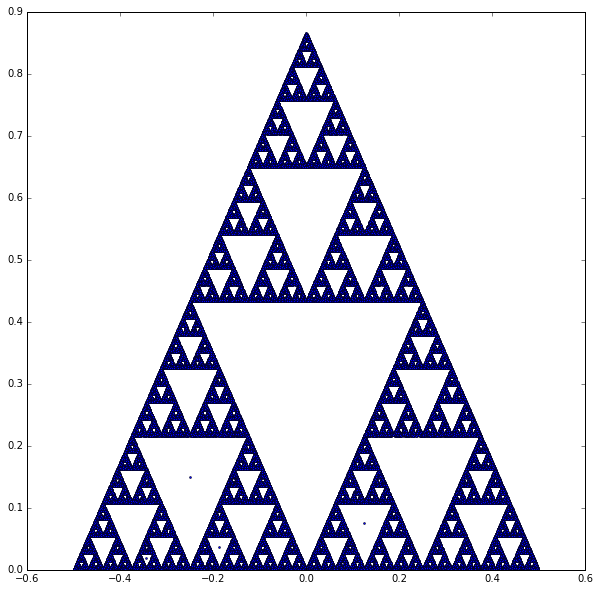

In [8]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(x,y,ls= 'None',marker="o",markersize=2)

In [20]:
class integration:
    def __init__(self,x,f):
        self.x=x      # x
        self.f=f      # f
        self.fx=f(x)  # f(x)
    def rectangle(self):
        dx=x[1]-x[0]
        return np.sum( (f(x+dx) *dx) [0:-1] )
    def simpson(self):
        return scipy.integrate.simps(self.fx,self.x)
    def gaussian_quad(self):
        return scipy.integrate.quadrature(f, x[0], x[-1])[0]
    def plot(self):
        plt.plot(self.x,self.fx,'ro')
        plt.xlim(xmin=self.x[0],xmax=self.x[-1])
        plt.show()

In [31]:
def f(x):
    #return x-x+1.
    return np.cos(x)
x=np.linspace(0.,2.*np.pi,1e3)

myfunc=integration(x,f)

result1=myfunc.rectangle()
result2=myfunc.simpson()
result3=myfunc.gaussian_quad()

print result1,result2,result3

1.11022302463e-16 -2.07329199009e-08 -4.49961195257e-12


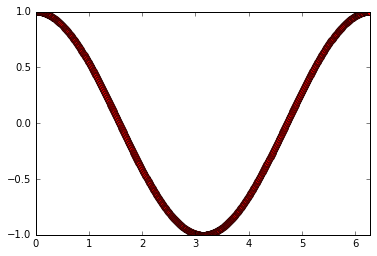

In [32]:
myfunc.plot()

Learn Scrapy

https://jessesw.com/Data-Science-Skills/

In [3]:
import nltk
nltk.download()

ImportError: No module named nltk

In [4]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, "lxml") # Get the html from the site
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    text = soup_obj.get_text() # Get the text from this
    lines = (line.strip() for line in text.splitlines()) # break into lines
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
        
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
               
    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
       
    text = text.lower().split()  # Go to lower case and split them apart

    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]

    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)        
    return text

In [26]:
sample = text_cleaner('http://www.104.com.tw/job/?jobno=4ql0y&jobsource=n104bank1&hotjob_chr=')
sample[:1000] # Just show the first 20 words

['reserved.',
 'pmp',
 'text',
 'one',
 'api',
 'mysql',
 'sas',
 'ie',
 'ecommerce',
 'ecrmfacebookfb',
 'mysqlhtmle',
 '..',
 'media',
 'commercesasspss',
 'hadoop',
 '.',
 '3',
 'mail',
 '3f',
 '...',
 'mining',
 'python',
 'big',
 '.spark',
 '3.facebook',
 'fb',
 'datasocial',
 'know',
 'e',
 'rights',
 'cpc',
 '.e',
 'spss',
 'r',
 'corporation']

In [5]:
sample = text_cleaner('http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed')
sample[:20] # Just show the first 20 words

['professionally.',
 'code',
 'help',
 'indeed',
 'searchclose',
 'competitive',
 'month',
 'scientist',
 'frequency',
 'per',
 'human',
 'keywords',
 'follow',
 'taiwan',
 'find',
 'access',
 'retirement',
 'terms',
 'candidate',
 'title']

In [16]:
a=["new Maxico city", "new york"]

a.split()

AttributeError: 'list' object has no attribute 'split'

http://www.w3schools.com/html/html_attributes.asp

learn: the use of the split method:

https://docs.python.org/2/library/stdtypes.html

In [22]:
a = "Free your mind."
b = "Welcome to the desert... of the real."
c = "What is real? How do you define real?"
 
print(a)
print(a.split())
print()
 
print(b)
print(b.split("o"))
print()
 
print(c)
print(c.split(" ", 2))
print()


print '+'.join("abc")

Free your mind.
['Free', 'your', 'mind.']
()
Welcome to the desert... of the real.
['Welc', 'me t', ' the desert... ', 'f the real.']
()
What is real? How do you define real?
['What', 'is', 'real? How do you define real?']
()
a+b+c


Beautiful soup

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [3]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""

In [14]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')

In [16]:
print soup.find_all("p")[0]
print soup.find_all("p")[0].get("class")

<p class="title"><b>The Dormouse's story</b></p>
[u'title']


In [5]:
print soup.find_all('a')

[<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>, <a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>, <a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>]


In [32]:
for link in soup.find_all('a'):
    print type(link)
    print(link.get('href'))

<class 'bs4.element.Tag'>
http://example.com/elsie
<class 'bs4.element.Tag'>
http://example.com/lacie
<class 'bs4.element.Tag'>
http://example.com/tillie


In [8]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        job_URLS = [base_url + str(link.get('href') ) for link in job_link_area.find_all('a')] # Get the URLS for the jobs ?????
            
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

There were 218 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Done with collecting the job postings!
There were 150 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


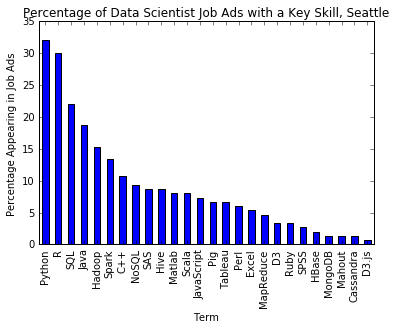

In [9]:
seattle_info = skills_info(city = 'Seattle', state = 'WA') 

There were 342 jobs found, San Francisco
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Done with collecting the job postings!
There were 227 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


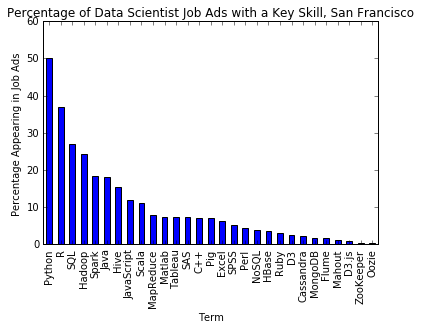

In [10]:
sf_info = skills_info(city = 'San Francisco', state = 'CA') 

There were 369 jobs found, New York
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Done with collecting the job postings!
There were 287 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


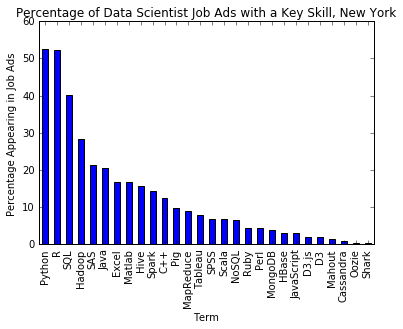

In [12]:
sf_info = skills_info(city = 'New York', state = 'NY') 

In [ ]:
hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
        'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
        'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
        'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
        'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})

In [23]:
sf_info = skills_info() 

There were 3167 jobs found, Nationwide
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5


KeyboardInterrupt: 